# Sentiment Analysis on IMDB Reviews using LSTM and Keras

In [2]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from tensorflow.keras.layers import Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\codya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
data = pd.read_csv('IMDB Dataset.csv')

print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [5]:
english_stops = set(stopwords.words('english'))

## Load and Clean Dataset
### Encode Sentiments

In [6]:
def load_dataset():
    df = pd.read_csv('IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


### Split Dataset

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
35462    [r, unredeemable, merit, less, dreary, trash, ...
3607     [this, one, films, looks, dated, way, part, fu...
46969    [of, adaptations, books, alistair, maclean, i,...
48676    [i, think, i, went, first, school, somewhere, ...
19259    [the, details, the, big, trail, incredible, i,...
                               ...                        
39564    [sasquatch, hunters, actually, bad, i, thought...
25020    [the, bourne, ultimatum, begins, recklessly, m...
22150    [halfway, season, got, caught, school, activit...
37431    [the, filmmaker, stayed, true, accurate, accou...
19423    [it, hard, explain, show, grown, friends, i, b...
Name: review, Length: 40000, dtype: object 

41603    [this, movie, terrific, even, less, convincing...
20138    [the, original, trancers, means, great, movie,...
29989    [there, many, film, dvd, producers, forgotten,...
24304    [in, immediate, aftermath, following, world, w...
28872    [i, got, laughs, one, lot, called, comedies, t...
 

In [8]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Tokenize and Pad/Truncate Reviews

In [9]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[ 1111 23828  3438 ...   262    46    18]
 [    8     5    35 ...   182   160   833]
 [  277  4826  1114 ...     0     0     0]
 ...
 [ 2669   792    97 ...     0     0     0]
 [    2  1629  2646 ...     0     0     0]
 [    7   157  1144 ...     0     0     0]] 

Encoded X Test
 [[    8     3  1252 ...   877   276    22]
 [    2   118 19268 ...   929  1121 19268]
 [   49    36     4 ...     1 26398  3648]
 ...
 [13993     9 30192 ...     0     0     0]
 [    1   164   826 ...     0     0     0]
 [    8    28  1425 ...     0     0     0]] 

Maximum review length:  130


## Build Architecture/Model

In [10]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2950528   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2975425 (11.35 MB)
Trainable params: 2975425 (11.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Training

In [11]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7279
Epoch 1: accuracy improved from -inf to 0.72793, saving model to models\LSTM.h5
313/313 [==============================] - 32s 97ms/step - loss: 0.5070 - accuracy: 0.7279
Epoch 2/5
  1/313 [..............................] - ETA: 29s - loss: 0.1570 - accuracy: 0.9531

c:\Users\codya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9163
Epoch 2: accuracy improved from 0.72793 to 0.91632, saving model to models\LSTM.h5
313/313 [==============================] - 30s 97ms/step - loss: 0.2326 - accuracy: 0.9163
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9601
Epoch 3: accuracy improved from 0.91632 to 0.96010, saving model to models\LSTM.h5
313/313 [==============================] - 31s 99ms/step - loss: 0.1286 - accuracy: 0.9601
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9782
Epoch 4: accuracy improved from 0.96010 to 0.97822, saving model to models\LSTM.h5
313/313 [==============================] - 32s 101ms/step - loss: 0.0765 - accuracy: 0.9782
Epoch 5/5
313/313 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9856
Epoch 5: accuracy improved from 0.97822 to 0.98558, saving model to models\LSTM.h5
313/313 [===============

KeyError: 'val_accuracy'

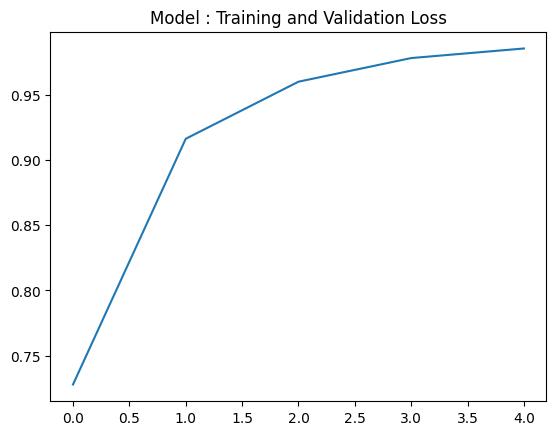

In [12]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

plt.title('Model : Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

## Testing

In [ ]:
y_pred = model.predict(x_test, batch_size = 128)

79/79 [==============================] - 2s 23ms/step


In [ ]:
# Convert predictions to binary (0 or 1)
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]

# Compute accuracy
accuracy = np.mean(np.array(y_pred_binary) == np.array(y_test))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.96%


In [ ]:
# Compare predictions with actual labels
correct_predictions = np.sum(np.array(y_pred_binary) == np.array(y_test))
wrong_predictions = len(y_test) - correct_predictions

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Wrong Predictions: {wrong_predictions}")

Number of Correct Predictions: 8696
Number of Wrong Predictions: 1304


In [ ]:
loss, _ = model.evaluate(x_test, y_test, verbose=0)  # 'verbose=0' ensures no output during evaluation
print(f"Test Loss: {loss:.4f}")

Test Loss: 0.5019


La loss de test est 0.5019 et le training loss est de 0.532. Le modèle underfit légèrement.

## Improving the Model


In [ ]:
# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [ ]:
def build_model(architecture_type):
    model = Sequential()

    if architecture_type == 'basic_lstm':
        model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
        model.add(LSTM(LSTM_OUT))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture_type == 'deeper_lstm':
        model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
        model.add(LSTM(LSTM_OUT, return_sequences=True))
        model.add(LSTM(LSTM_OUT))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture_type == 'bidirectional_lstm':
        model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
        model.add(Bidirectional(LSTM(LSTM_OUT)))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture_type == 'lstm_with_dropout':
        model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
        model.add(LSTM(LSTM_OUT, dropout=0.25, recurrent_dropout=0.25))
        model.add(Dense(1, activation='sigmoid'))

    # ... add more architectures as needed

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Training model with basic_lstm architecture...
Epoch 1/3
282/282 [==============================] - 24s 83ms/step - loss: 0.5398 - accuracy: 0.6856 - val_loss: 0.3108 - val_accuracy: 0.8777
Epoch 2/3
282/282 [==============================] - 25s 90ms/step - loss: 0.2429 - accuracy: 0.9112 - val_loss: 0.3144 - val_accuracy: 0.8863
Epoch 3/3
282/282 [==============================] - 25s 87ms/step - loss: 0.1338 - accuracy: 0.9573 - val_loss: 0.3520 - val_accuracy: 0.8763
Training model with deeper_lstm architecture...
Epoch 1/3
282/282 [==============================] - 56s 194ms/step - loss: 0.4131 - accuracy: 0.7952 - val_loss: 0.2867 - val_accuracy: 0.8783
Epoch 2/3
282/282 [==============================] - 56s 199ms/step - loss: 0.1917 - accuracy: 0.9324 - val_loss: 0.3047 - val_accuracy: 0.8748
Epoch 3/3
282/282 [==============================] - 53s 189ms/step - loss: 0.1102 - accuracy: 0.9644 - val_loss: 0.3806 - val_accuracy: 0.8645
Training model with bidirectional_lstm archi

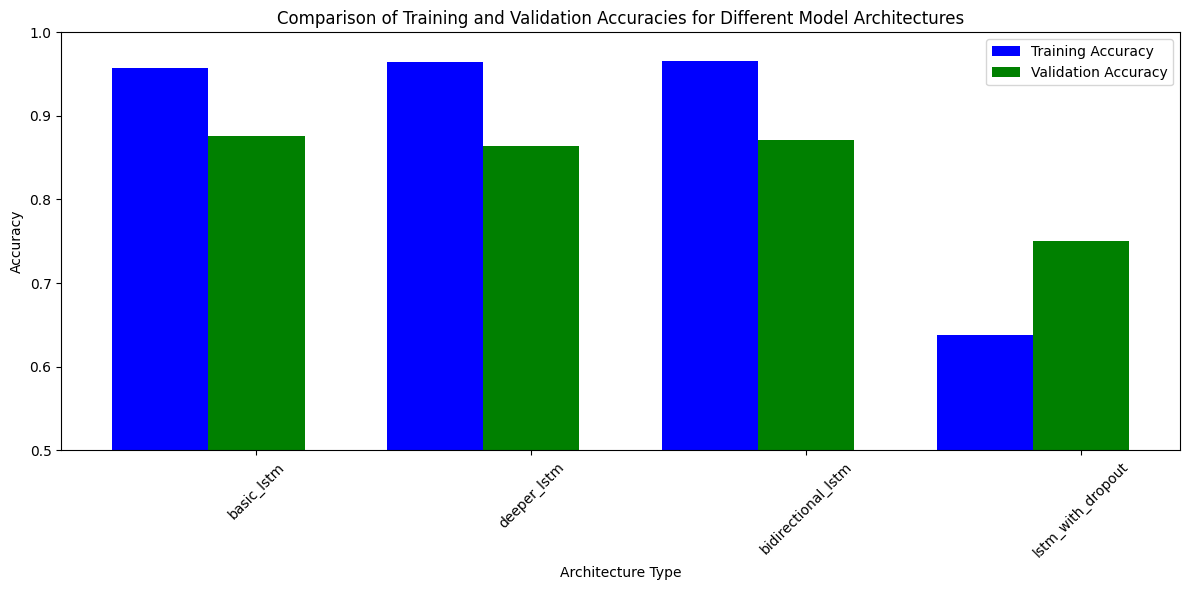

In [ ]:
architecture_types = ['basic_lstm', 'deeper_lstm', 'bidirectional_lstm', 'lstm_with_dropout']
train_accuracies = []
val_accuracies = []

for architecture_type in architecture_types:
    print(f"Training model with {architecture_type} architecture...")
    model = build_model(architecture_type)
    history = model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1, validation_data=(x_val, y_val))

    # Capturing accuracies from the training history
    train_accuracies.append(history.history['accuracy'][-1])  # last epoch training accuracy
    val_accuracies.append(history.history['val_accuracy'][-1])  # last epoch validation accuracy

# Plotting the accuracies
plt.figure(figsize=(12, 6))

# Bar width
bar_width = 0.35

# Setting the positions of bars
r1 = np.arange(len(architecture_types))
r2 = [x + bar_width for x in r1]

plt.bar(r1, train_accuracies, width=bar_width, color='blue', label='Training Accuracy')
plt.bar(r2, val_accuracies, width=bar_width, color='green', label='Validation Accuracy')

plt.xlabel('Architecture Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Validation Accuracies for Different Model Architectures')
plt.xticks([r + bar_width for r in range(len(architecture_types))], architecture_types, rotation=45)
plt.ylim([0.5, 1])  # assuming accuracy is between 0.5 and 1
plt.legend()
plt.tight_layout()
plt.show()

On remarque que le modèle avec le meilleur accuracy est le modèle bidirectionnel.
Cependant, on notera qu'ils sont tous très proches les uns des autres. Mis à part le modèle avec dropout (qui ajoute du bruit au neurones) qui est bien moins bon.